In [326]:
import ROOT, rat
import os, sys
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
sys.path.append('/home/jp/projects/python_tools')
import jp_mpl as jplot
import rat
from itertools import cycle
from scipy.stats import truncnorm

In [2]:
gaus = lambda x, normalization, mean, sigma: normalization * np.exp(-0.5 * (x - mean)**2 / sigma**2)
two_gaus = lambda x, n1, m1, s1, n2, m2, s2: gaus(x, n1, m1, s1) + gaus(x, n2, m2, s2)
from scipy import optimize

def getNorm(v):
    return v/np.sqrt(np.sum(v**2))
def renormN(n, axis=0):
    n+= 1E-9

    integral = np.sum(n,axis=axis)
    if axis==0:
        return n/integral
    else:
        return (n.T/integral).T

###  Start here if you have already loaded/selected the tracks

In [3]:
import pickle
data = pickle.load(open('/home/jp/projects/snoplus/rundir/greydisc_validation/onepmt_geo/condensed.pckl'))


Slice of the deepest point reflected photons touch
5413


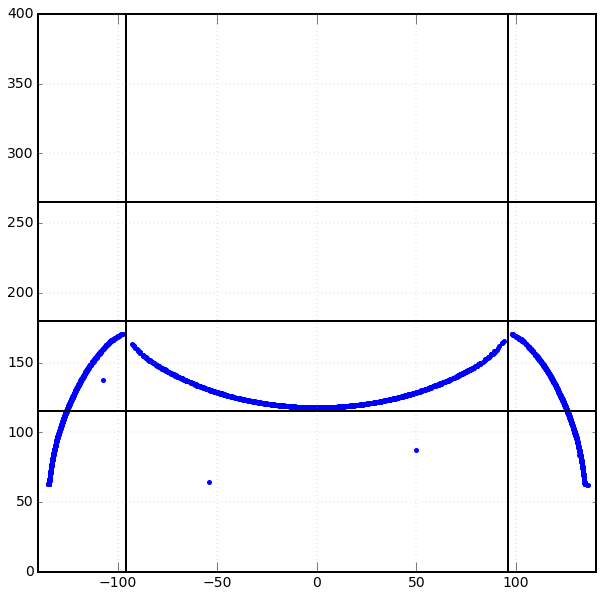

In [4]:
print 'Slice of the deepest point reflected photons touch'
yz_center = 0
tol = 10 # mm
ybool = (data['xr'][:,1] > (yz_center-tol) )*(data['xr'][:,1]< (yz_center+tol) )
print np.sum(ybool)
plt.figure(figsize=(10,10))
plt.plot(data['xr'][ybool,2], data['xr'][ybool,0], '.')
plt.xlim([-140,140])
plt.ylim(0,400)
plt.axhline(y=180, xmin=-140, xmax=140, color='k')
pmt_radius = 192./2
plt.axvline(x=pmt_radius, ymin=0, ymax=300, color='k')
plt.axvline(x=-pmt_radius, ymin=0, ymax=300, color='k')

plt.axhline(y=115, xmin=-140, xmax=140, color='k')
plt.axhline(y=265, xmin=-140, xmax=140, color='k')


In [5]:
# Only focus on photons reflected at PMT/concentrator - nothing deeper
ibool = data['xr'][:,0] < 180

# Now let's pick pmt reflections
reflect_pmt = (np.sqrt(np.sum(data['xr'][:,1:]**2,axis=1)) < pmt_radius)*ibool
reflect_conc = (np.sqrt(np.sum(data['xr'][:,1:]**2,axis=1)) > pmt_radius)*ibool

print np.sum(reflect_pmt), np.sum(reflect_conc)

8786 75255


Slice of the deepest point reflected photons touch
52164


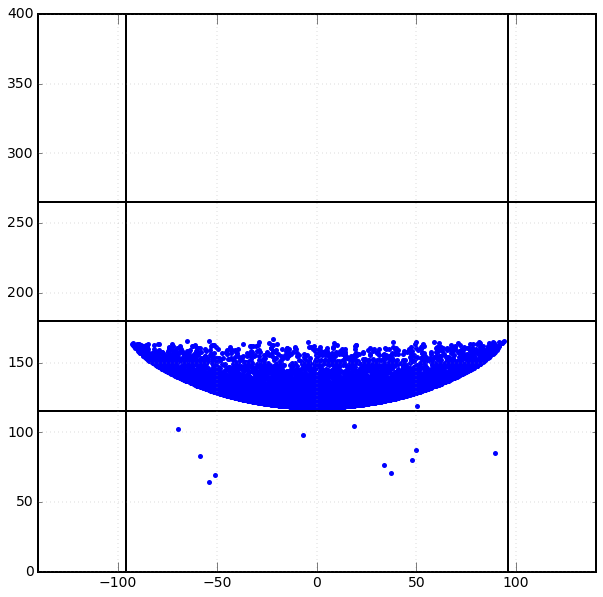

In [6]:
print 'Slice of the deepest point reflected photons touch'
mybool = reflect_pmt
yz_center = 0
tol = 100 # mm
ybool = (data['xr'][:,1] > (yz_center-tol) )*(data['xr'][:,1]< (yz_center+tol) )
print np.sum(ybool)
plt.figure(figsize=(10,10))
plt.plot(data['xr'][ybool*mybool,2], data['xr'][ybool*mybool,0], '.')
plt.xlim([-140,140])
plt.ylim(0,400)
plt.axhline(y=180, xmin=-140, xmax=140, color='k')
pmt_radius = 192./2
plt.axvline(x=pmt_radius, ymin=0, ymax=300, color='k')
plt.axvline(x=-pmt_radius, ymin=0, ymax=300, color='k')

plt.axhline(y=115, xmin=-140, xmax=140, color='k')
plt.axhline(y=265, xmin=-140, xmax=140, color='k')


In [7]:
# For all the stored photons, I know who reflected them
# Can I use my ellipsoid formula to find out?

def pmtContactTime( x0, y0, z0, u, v, w):
    # x0, y0, z0 are the starting point
    # u, v, w are the velocity components
    # ae, ce are ellipsoid characteristics
    ae = 203.7/2.
    ce = 150.3/2.
    a = w**2 / ce**2 + (u**2+v**2)/ae**2
    b = 2*((u*x0+v*y0)/ae**2 + w*z0/ce**2)
    c = (x0**2 + y0**2)/ae**2 + z0**2/ce**2 -1
    
    inner_sqrt = b**2 -4*a*c
    #print inner_sqrt
    if inner_sqrt < 0:
        return 0.
    
    sol1 = (-b+np.sqrt(inner_sqrt))/(2*a)
    sol2 = (-b-np.sqrt(inner_sqrt))/(2*a)
    
    if sol1 > 0 and sol2 < 0:
        return sol1
    if sol2 > 0 and sol1 < 0:
        return sol2
    if sol1 > 0 and sol2 > 0:
        return np.min([sol1, sol2])
    if sol1 < 0 and sol2 < 0:
        return 0.
    
    
    

def pmtContactDepth(z0, w, t):
    return z0 + t*w

In [8]:
data.keys()

['theta_f',
 'y',
 'phi_f',
 'theta_i',
 'xr',
 'r',
 'phidiff',
 'phi_i',
 'z',
 'momentum']

In [9]:
# The momentum is not a unit vector. Don't know why. Renormalizing it
momentum_norm = np.linalg.norm(data['momentum'],axis=1)
momentum_norm = momentum_norm.reshape(momentum_norm.size, 1)
data['momentum'] /= momentum_norm

In [10]:
# Finding almost straight photons
straight = data['momentum'][:,0] > 0.99
print np.sum(straight)
outer_rim = data['r'] > 120.
inner_rim = data['r'] < 70.
print np.sum(outer_rim), np.sum(inner_rim)
#tbool = straight*outer_rim
tbool = straight*inner_rim
print np.sum(tbool)

print '\n These are PMT hits'
print np.where(tbool == True)[0]

print '\n These are CONCENTRATOR hits'
tbool = straight*outer_rim
print np.where(tbool == True)[0]


295
14321 25705
97

 These are PMT hits
[  378   534   861  1442  1824  2405  5566  6461  6952  8804  9125 10760
 11378 13706 16273 16607 17408 18490 21217 23101 23756 24342 24637 27625
 29140 29217 30084 31189 32150 32332 33090 34718 36544 38515 38570 39190
 39219 39878 42119 44820 45345 45782 45914 47029 47594 47954 47977 48243
 48857 48940 49255 50507 51381 53775 53918 53948 54971 56400 56691 56725
 56980 57508 59618 59928 60270 60345 60968 62661 62772 63972 64294 66391
 66586 67159 67438 68478 68996 70191 70385 71137 73897 73995 74225 75033
 75126 75722 76311 76466 76961 77152 77314 78668 78912 80018 81363 82237
 83689]

 These are CONCENTRATOR hits
[ 8104  9391 11900 12718 17073 18249 19557 24336 24408 25981 26691 26763
 28154 29195 41275 41411 41652 42913 45549 45646 48053 49652 50583 54051
 54195 57459 59663 59734 61786 63661 63682 65358 69422 69441 72549 73151
 76278 76803 77685 80528 84017]


In [11]:
ievent = 112

print 'Raw information'
print data['y'][ievent], data['z'][ievent]
print data['momentum'][ievent], '\n'

print 'Reflected PMT or CONC?', reflect_pmt[ievent], reflect_conc[ievent]

# The z0 is always equal to 13.18 - see diagram
x0 = data['z'][ievent]
y0 = data['y'][ievent]
z0 = 132.8

u = data['momentum'][ievent,2]
v = data['momentum'][ievent,1]
w = -data['momentum'][ievent,0]

print 'Position', x0, y0, z0
print 'Momentum', u, v, w

t = pmtContactTime(x0,y0,z0, u,v,w)
z = pmtContactDepth(z0, w, t)
print x0 + t*u
print y0 + t*v
print '\n',t, z

Raw information
75.1770095825 -102.478012085
[ 0.36209039 -0.44626586  0.81837481] 

Reflected PMT or CONC? False True
Position -102.478012085 75.1770095825 132.8
Momentum 0.818374810904 -0.446265864129 -0.362090385665
-102.478012085
75.1770095825

0.0 132.8


In [12]:
mom = np.array( [8.97984137e-07,  -1.10673932e-06,   2.02956949e-06])
mom /= np.linalg.norm(mom)
print mom

[ 0.36209039 -0.44626586  0.81837481]


In [13]:
my_times = np.zeros_like(data['r'])
my_z     = np.zeros_like(my_times)
for ievent in range(len(data['r'])):
    x0 = data['z'][ievent]
    y0 = data['y'][ievent]
    z0 = 133.2

    u = data['momentum'][ievent,2]
    v = data['momentum'][ievent,1]
    w = -data['momentum'][ievent,0]
    t = pmtContactTime(x0,y0,z0, u,v,w)
    z = pmtContactDepth(z0, w, t)
    my_times[ievent] = t
    my_z[ievent] = z

/home/jp/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:6365: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


18.5
Everything below 26mm actually hit the concentrator


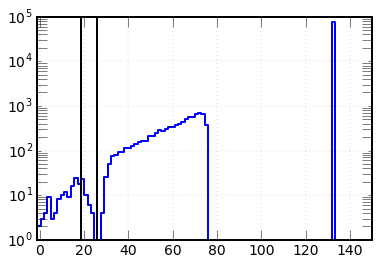

In [14]:
xaxis = np.linspace(-1, 150, 101)
b, x = np.histogram(my_z, xaxis)
jplot.unfilledBar(x,b)
plt.yscale('log')
plt.axvline(131.8-113.3, 0.001, 1000, color='k')
plt.axvline(26, 0.001, 1000, color='k')
print 131.8-113.3
print 'Everything below 26mm actually hit the concentrator'

In [15]:
pmt_hits = (my_z < 100)*(my_z > 26)
conc_hits = (my_z > 100) + (my_z < 26)

print 'PMT hits', np.sum((my_z < 100)*(my_z > 26))
print 'Concentrator hits', np.sum(my_z > 100)+np.sum(my_z < 26)


PMT hits 8806
Concentrator hits 75235


In [16]:
mismatch = pmt_hits != reflect_pmt
print np.sum(mismatch)

82


Slice of the deepest point reflected photons touch


(-150, 150)

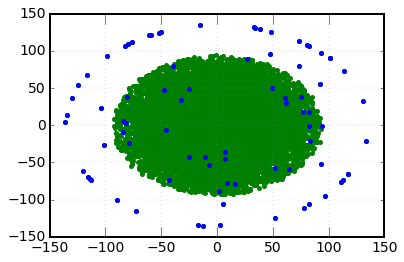

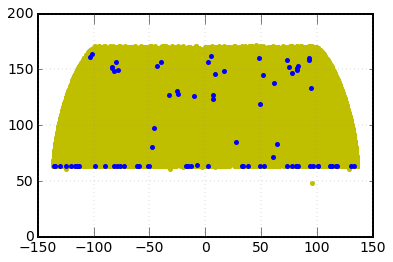

In [17]:
print 'Slice of the deepest point reflected photons touch'
mybool = mismatch
plt.figure()
plt.plot(data['xr'][pmt_hits,1], data['xr'][pmt_hits,2], '.g')
#plt.plot(data['xr'][reflect_pmt,1], data['xr'][reflect_pmt,2], '.r')
#plt.plot(data['xr'][conc_hits,1], data['xr'][conc_hits,2], '.y')
#plt.plot(data['xr'][reflect_conc,1], data['xr'][reflect_conc,2], '.c')

plt.plot(data['xr'][mybool,1], data['xr'][mybool,2], '.')

plt.ylim(-150,150)
plt.xlim(-150,150)

plt.figure()

plt.plot(data['xr'][conc_hits,1], data['xr'][conc_hits,0], '.y')
plt.plot(data['xr'][mybool,1], data['xr'][mybool,0], '.')
plt.ylim(0,200)
plt.xlim(-150,150)


In [18]:
print 'Mismatches are due to the exact size of the grey disc'
print 'The current implementation is a good classifier of PMT vs PETAL hit'

Mismatches are due to the exact size of the grey disc
The current implementation is a good classifier of PMT vs PETAL hit


In [19]:
# Change the theta to do it as a function of cos(theta) - it might show up more interesting correlations
gdr = 138.
def plotReflections(data, sel):
    fig = plt.figure(figsize=(16,14))

    ### First figure - incoming vs diff
    ax1 = fig.add_subplot(221)

    x1 = np.linspace(0, np.pi/2., 41)
    x2 = np.linspace(-np.pi/2, np.pi/2., 51)
    n, x1, x2 = np.histogram2d(data['theta_i'][sel], 
                               data['theta_f'][sel] - data['theta_i'][sel], 
                               [x1,x2])
    n = renormN(n,axis=1)
    plt.pcolor(np.rad2deg(x1),
               np.rad2deg(x2),
               n.T)
    plt.xlabel('Incoming theta (deg)')
    plt.ylabel('theta_f - theta_i (deg)')
    plt.colorbar()
    plt.title('Outgoing theta - incoming')
    #plt.yticks(np.arange(-90, 90, 5.0))

    
    
    ### Second figure - function of radius
    ax2 = fig.add_subplot(222)
    x1 = np.linspace(0, gdr, 41)
    x2 = np.linspace(-np.pi/2, np.pi/2., 51)
    n, x1, x2 = np.histogram2d(data['r'][sel], 
                               data['theta_f'][sel] - data['theta_i'][sel], 
                               [x1,x2])
    n = renormN(n,axis=1)
    plt.pcolor(x1,
               np.rad2deg(x2),
               n.T)
    plt.xlabel('Radius (mm)')
    plt.ylabel('theta_f - theta_i (deg)')
    plt.colorbar()
    plt.title('Theta difference vs radius')
    
    
    ### Third figure - cos(theta) incoming vs outgoing
    ax3 = fig.add_subplot(223)
    x1 = np.linspace(0, 1., 41)
    x2 = np.linspace(-1, 1., 51)
    n, x1, x2 = np.histogram2d(np.cos(data['theta_i'][sel]), 
                               np.cos(data['theta_f'][sel])-\
                               np.cos(data['theta_i'][sel]), 
                               [x1,x2])
    n = renormN(n,axis=1)
    plt.pcolor(x1,
               x2,
               n.T)
    plt.xlabel('cos(theta_i)')
    plt.ylabel('cos(theta_f) - cos(theta_i)')
    plt.colorbar()
    plt.title('Outgoing theta vs radius')  
    
    # Fourth figure - function of contact position
    ax4 = fig.add_subplot(224)
    iev  = 500
    prob = iev*1./len(sel)
    randsel = sel*(np.random.rand(len(sel)) < prob)
    plt.quiver(data['y'][randsel], 
               data['z'][randsel],
               np.cos(data['theta_f'][randsel]), 
               np.sin(data['phi_f'][randsel]))
    plt.xlabel('y (mm)')
    plt.ylabel('z (mm)')

    plt.title('Outgoing theta vs radius') 
    
    
    

    # New figure - everything for phi
    fig2 = plt.figure(figsize=(16,14))

    
    ### Figure
    axb = fig2.add_subplot(221)

    x1 = np.linspace(-np.pi, np.pi, 41)
    x2 = np.linspace(0, np.pi*2, 51)
    n, x1, x2 = np.histogram2d(data['phi_i'][sel], 
                               data['phidiff'][sel], [x1,x2])
    n = renormN(n,axis=1)
    plt.pcolor(np.rad2deg(x1),
               np.rad2deg(x2),
               n.T)
    plt.xlabel('Incoming phi (deg)')
    plt.ylabel('phi_f - phi_i (deg)')
    plt.colorbar()
    plt.title('Outgoing phi - incoming')

    
    ## Phi change vs radius
    axb2 = fig2.add_subplot(222)
    x1 = np.linspace(0, 138., 41)
    x2 = np.linspace(0, np.pi*2, 51)
    n, x1, x2 = np.histogram2d(data['r'][sel], 
                               data['phidiff'][sel], 
                               [x1,x2])
    n = renormN(n,axis=1)
    plt.pcolor(x1,
               np.rad2deg(x2),
               n.T)
    plt.xlabel('Radius (mm)')
    plt.ylabel('phi_f - phi_i (deg)')
    plt.colorbar()
    plt.title('Phi difference vs radius')
    
    # Phi change vs incoming theta
    axb3 = fig2.add_subplot(223)
    x1 = np.linspace(0, np.pi/2., 41)
    x2 = np.linspace(0, np.pi*2, 51)
    n, x1, x2 = np.histogram2d(data['theta_i'][sel], 
                               data['phidiff'][sel], 
                               [x1,x2])
    n = renormN(n,axis=1)
    plt.pcolor(np.rad2deg(x1),
               np.rad2deg(x2),
               n.T)
    plt.xlabel('Incoming theta (deg)')
    plt.ylabel('phi_f - phi_i (deg)')
    plt.colorbar()
    plt.title('Phi difference vs incoming theta')    
    
    # Outpgoing phi as function of radius
    axb4 = fig2.add_subplot(224)

    
    # outgoing phi as a function of radius?
    plt.title('Change in phi vs radius')
    iev  = 500
    prob = iev*1./len(sel)
    randsel = sel*(np.random.rand(len(sel)) < prob)
    plt.quiver(data['y'][randsel], 
               data['z'][randsel],
               np.cos(data['phi_f'][randsel] - data['phi_i'][randsel]), 
               np.sin(data['phi_f'][randsel] - data['phi_i'][randsel]))
    plt.xlabel('y (mm)')
    plt.ylabel('z (mm)')

Selecting all the events


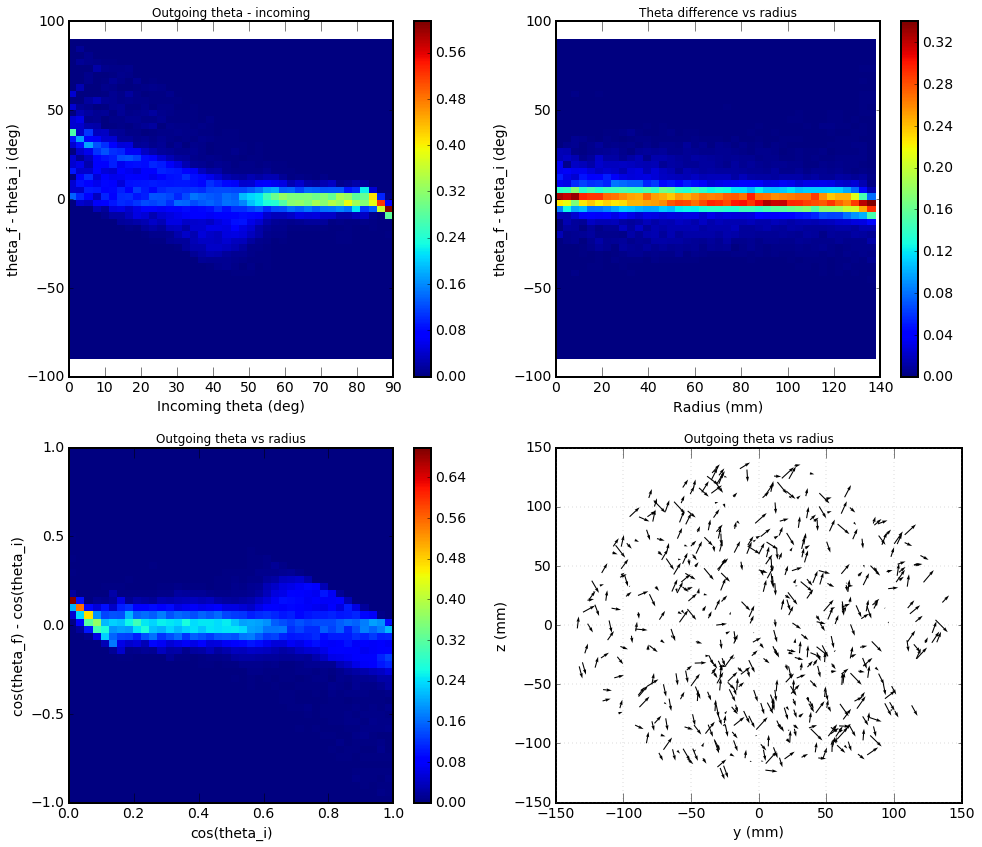

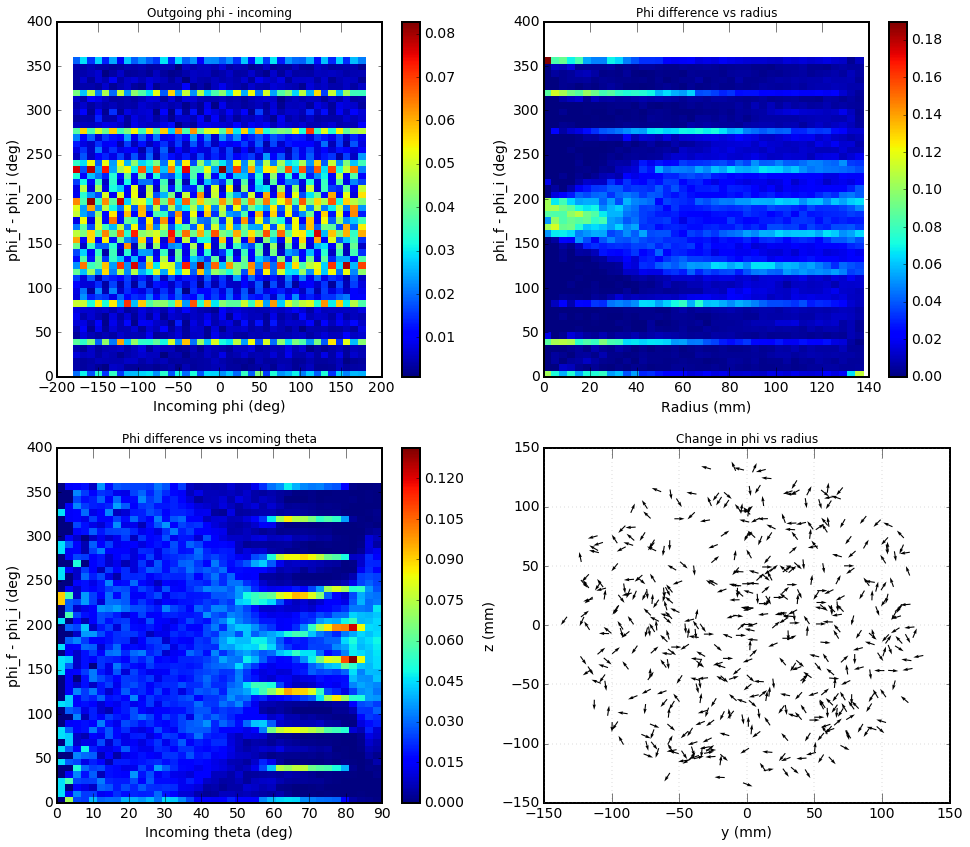

In [20]:
print 'Selecting all the events'
sel=( np.array([True]*len(data['y']))
     #*(data['z'] > 0)
     #*(data['r']>0)
    )
plotReflections(data,sel)


Selecting only the events that hit the PMT first


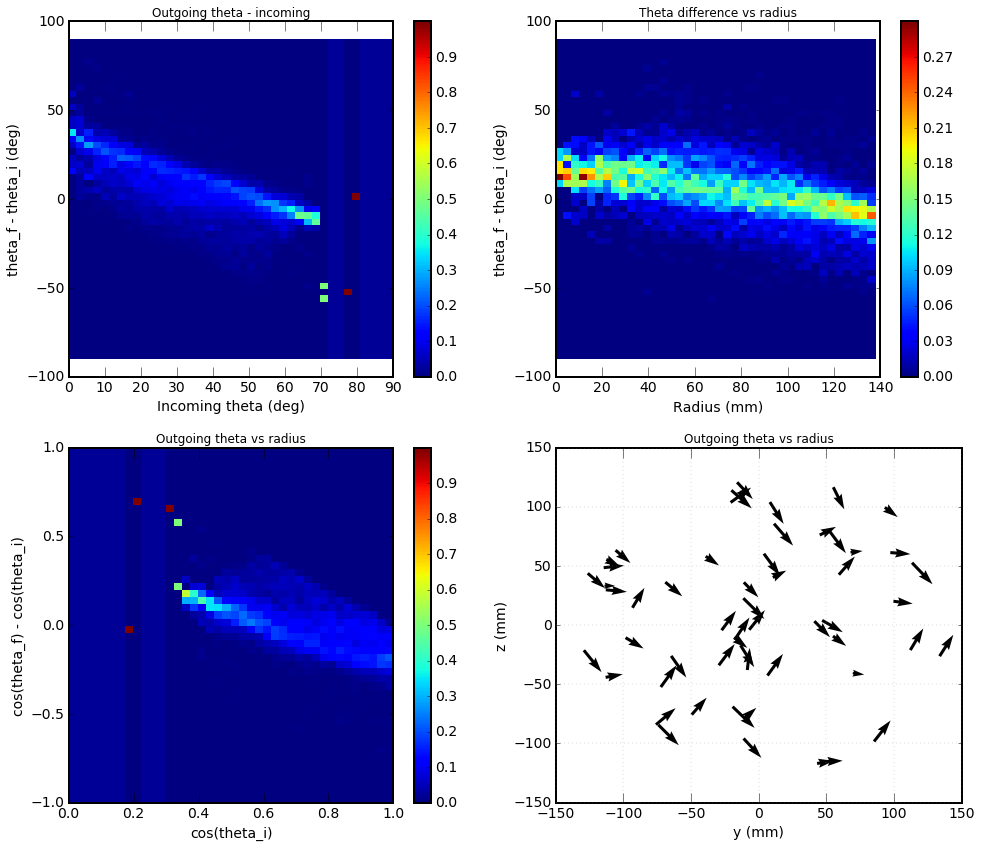

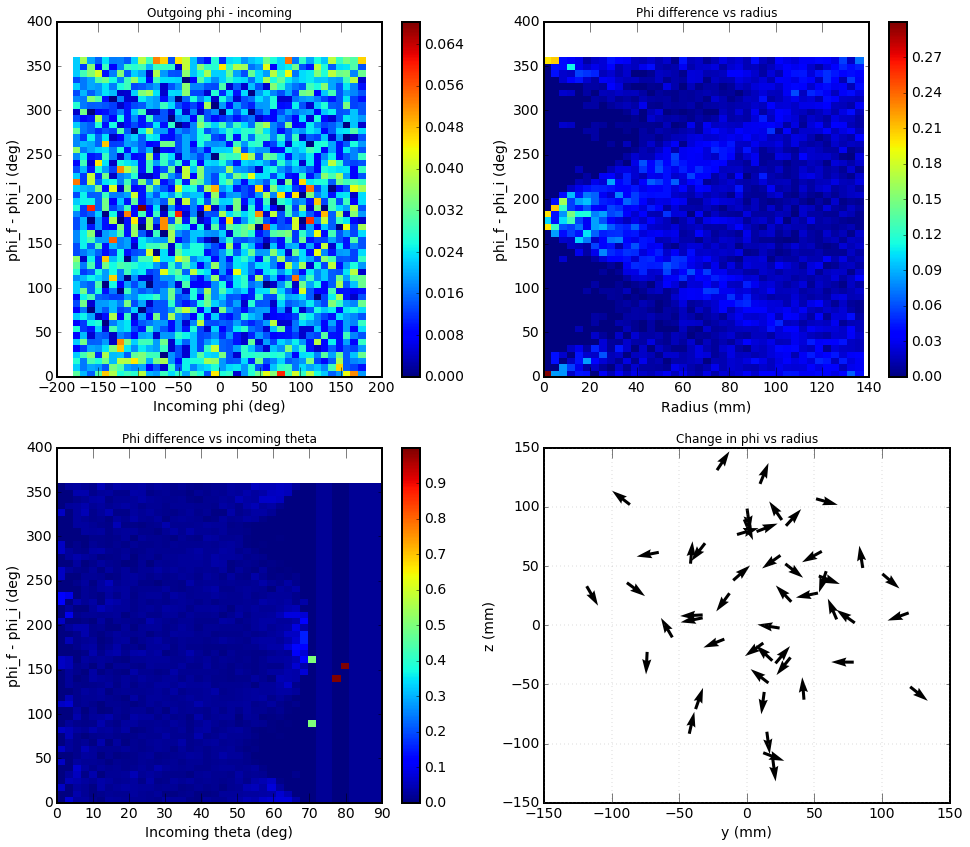

In [21]:
print 'Selecting only the events that hit the PMT first'
sel=( np.array([True]*len(data['y']))
     *reflect_pmt
     #*(data['z'] > 0)
     #*(data['r']>0)
    )
plotReflections(data,sel)


### Building the model for theta <br> This model will fully depend on the radius of the first impact point

Mean 15.5771658581 std 8.23501354648
Bin 0 
Mu1 15.096499004 std1 6.1679764931
Mean 14.0364608492 std 9.24576924151
Bin 1 
Mu1 13.5632971474 std1 6.12274335623
Mean 15.0325167846 std 10.1862962941
Bin 2 
Mu1 15.2089351774 std1 8.06834516465
Mean 13.4371895214 std 10.2296190619
Bin 3 
Mu1 13.1014003982 std1 9.64798615834
Mean 13.1733809133 std 12.2472042716
Bin 4 
Mu1 13.2894950311 std1 9.75483228778
Mean 12.5987801532 std 13.8433340571
Bin 5 
Mu1 12.4274004425 std1 11.6791009526
Mean 10.9029281574 std 13.4637879399
Bin 6 
Mu1 9.90214801691 std1 12.1454189737
Mean 8.14072477524 std 13.2628692955
Bin 7 
Mu1 8.02191115862 std1 11.8493887452
Mean 6.61840643995 std 13.7470858167
Bin 8 
Mu1 5.74057948285 std1 12.2855648148
Mean 4.31903031861 std 13.6660318235
Bin 9 
Mu1 3.77628832696 std1 11.3727915957
Mean 1.9142567058 std 13.4120495798
Bin 10 
Mu1 1.67209764058 std1 10.5475510985
Mean -0.159998878311 std 12.6306831407
Bin 11 
Mu1 0.852097117645 std1 10.0308127098
Mean -3.700801962 std 12.5

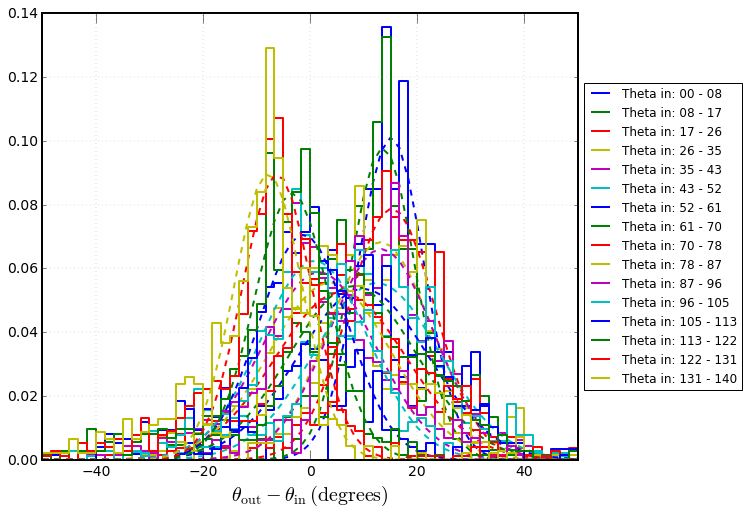

In [22]:
colors = cycle(['b','g','r','y','m','c'])
xaxis = np.linspace(-50,50, 61)

inregions = np.linspace(0, 140, 17)
fit_regions = (inregions[1:]+inregions[:-1])/2.
fit_mean = np.zeros(len(inregions)-1)
fit_std  = np.zeros_like(fit_mean)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for i in range(len(inregions)-1):
    sel=( np.array([True]*len(data['y']))
         *reflect_pmt
         *(data['r'] > inregions[i])
         *(data['r'] < inregions[i+1])
         #*(data['z'] > 0)
         #*(data['r']>0)
        )
    

    thisdata = np.rad2deg(data['theta_f'] - data['theta_i'])[sel]
    bins, x = np.histogram(thisdata, xaxis)
    
    p0 = [0.1, 10, 20]
    fit_fcn = gaus
    xfit = np.array([0.5 * (x[k] + x[k + 1]) for k in range(len(bins))])
    
    bins = bins*1./np.sum(bins)
    thiscolor= colors.next()
    
    #print bins, x
    print 'Mean', thisdata.mean(), 'std', thisdata.std()
    jplot.unfilledBar(x,bins, color=thiscolor, 
                      label = 'Theta in: %02i' % inregions[i] + ' - %02i' % inregions[i+1])

    
    # Fitting a single guassian
    
    popt, pcov = optimize.curve_fit(fit_fcn, xfit, bins, p0 = p0)

    print 'Bin', i, '\nMu1', popt[1], 'std1', popt[2]
    plt.plot(x, fit_fcn(x, *popt),
             color=thiscolor, linestyle = '--')
    
    fit_mean[i] = popt[1]
    fit_std[i]  = popt[2]
    
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r'$\theta_\mathrm{out} - \theta_\mathrm{in}\,\mathrm{(degrees)}$', fontsize=20)

Analizing the mean
            2
-0.0008774 x - 0.06135 x + 15.9


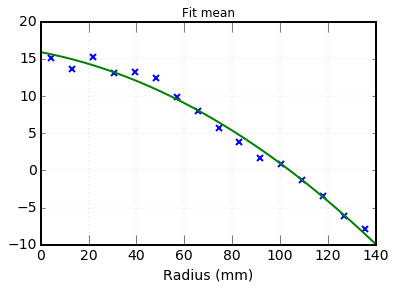

In [23]:
print 'Analizing the mean'
plt.plot(fit_regions, fit_mean, 'x')
p = np.polyfit(fit_regions, fit_mean, deg=2)
myx = np.linspace(0, 140, 101)
myfcn = np.poly1d(p)
plt.plot(myx, myfcn(myx))
plt.title('Fit mean')
plt.xlabel('Radius (mm)')
print myfcn

Analizing the standard deviation
This is the function between x=[15, 120]           2
-0.00201 x + 0.2699 x + 3.006
Outside it is equal to 6


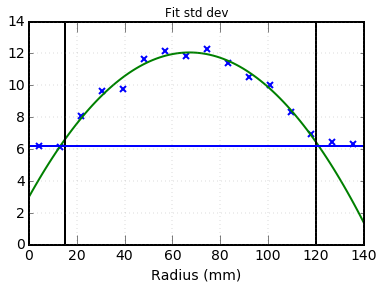

In [24]:
print 'Analizing the standard deviation'
plt.plot(fit_regions, fit_std, 'x')

# Fitting a guassian
#p0 = [11., 65., 30.]
#popt, pcov = optimize.curve_fit(fit_fcn, fit_regions[1:-1], fit_std[1:-1], p0 = p0)
#myx = np.linspace(0, 140, 101)
#plt.plot(myx, fit_fcn(myx, *popt))

# Fitting a polynomial
p = np.polyfit(fit_regions[1:-2], fit_std[1:-2], deg=2)
myfcn = np.poly1d(p)
plt.plot(myx, myfcn(myx))
plt.title('Fit std dev')
print 'This is the function between x=[15, 120]', myfcn
print 'Outside it is equal to 6'
plt.axvline(15, 0, 14, color = 'k')
plt.axvline(120, 0, 14, color = 'k')
plt.xlabel('Radius (mm)')
plt.axhline(6.2, 0, 140)


In [25]:
print 'Declaring the full function of the photons that hit the PMT'
def reflectParamsPMT(radius):
    # First define the mean - coefficients obtained from fitting PMT simulation
    mean = -0.0008774*radius**2 - 0.06135 *radius + 15.9
    
    # Then obtain the standard deviation - coefficients obtained the same way
    std_dev = 6.2
    if radius > 15. and radius < 120.:
        std_dev = -0.00201*radius**2 + 0.2699*radius + 3.006
        
    return mean, std_dev

Declaring the full function of the photons that hit the PMT


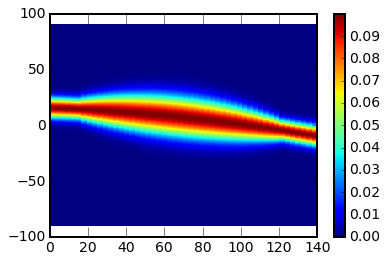

In [26]:
y = np.linspace(-90, 90, 1000.)
radius = np.linspace(0, 140, 51.)
output = np.zeros([len(radius), len(y)])

for i in range(len(radius)):
    mu, sigma = reflectParamsPMT(radius[i])
    output[i,:] = gaus(y, 0.1, mu, sigma)
    
plt.pcolor(radius, y, output.T)
plt.colorbar()



### Building the model for the phi angle

Selecting the events that hit the petals first


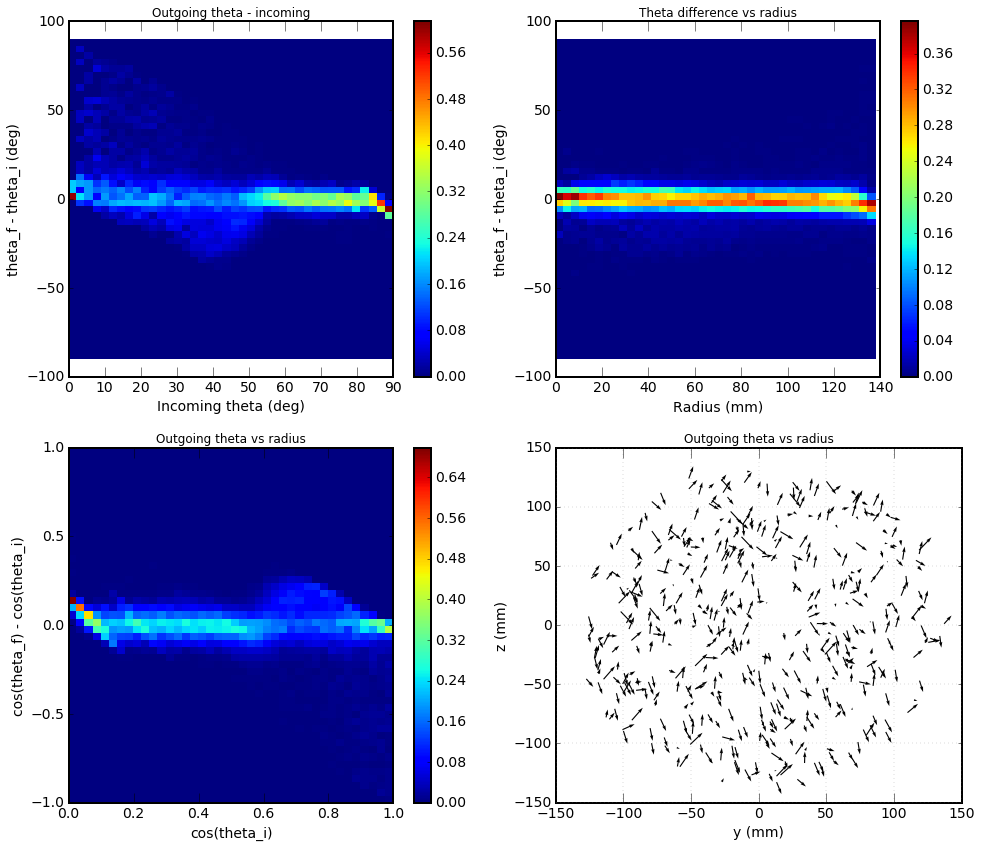

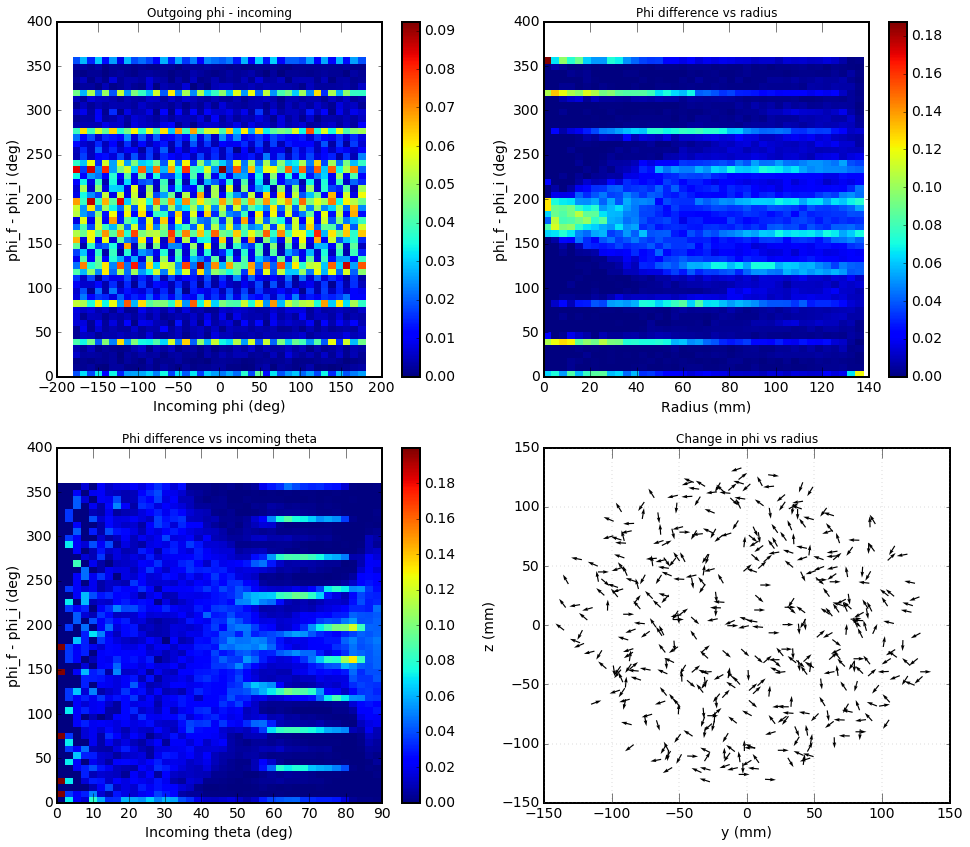

In [27]:
print 'Selecting the events that hit the petals first'
sel=( np.array([True]*len(data['y']))
     *reflect_conc
     #*((np.rad2deg(data['phidiff'])%10) > 5.)
     #*(data['z'] > 0)
     #*(data['r']>0)
    )
plotReflections(data,sel)


In [28]:
(np.rad2deg(data['phidiff'])%9) > 3

array([ True, False,  True, ...,  True,  True,  True], dtype=bool)

/home/jp/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 90 but corresponding boolean dimension is 91


Bin 0 
Mu1 161.54399835 std1 256.071304613
Bin 1 
Mu1 173.003031857 std1 167.62907376
Bin 2 
Mu1 202.750506491 std1 244.309223456
Bin 3 
Mu1 158.289448104 std1 235.252641268
Bin 4 did not converge
Bin 5 
Mu1 224.478774456 std1 240.686309829
Bin 6 
Mu1 178.33399556 std1 100.35122748
Bin 7 
Mu1 180.254330609 std1 69.392574955
Bin 8 
Mu1 177.943444221 std1 83.2140180123
Bin 9 
Mu1 177.939761207 std1 67.4285313552
Bin 10 
Mu1 174.545908033 std1 -43.8894033556
Bin 11 
Mu1 177.82333696 std1 -41.2876914174
Bin 12 
Mu1 181.559854858 std1 42.8744930893
Bin 13 
Mu1 179.74068348 std1 59.2125939233


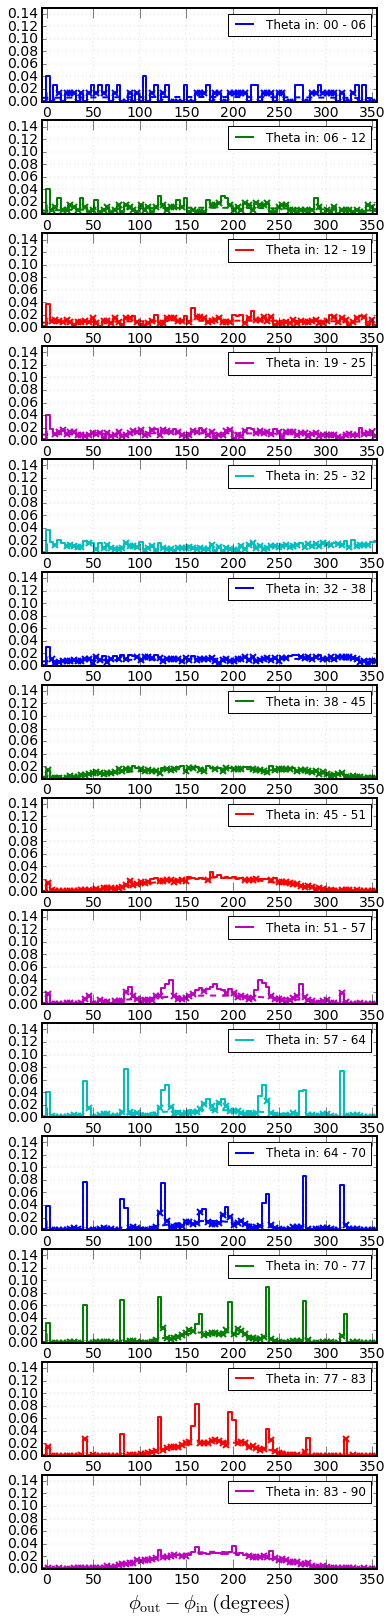

In [105]:
colors = cycle(['b','g','r','m','c'])
#xaxis = np.linspace(-2,2, 41)
xaxis = np.linspace(-5,355, 91)


fig = plt.figure(figsize=(6,30))
inregions = np.linspace(0, 90, 15)
fit_x   = (inregions[1:]+inregions[:-1])/2.
fit_std = np.zeros(len(inregions)-1)

peak_max = np.zeros(len(inregions)-1)
for i in range(len(inregions)-1):
    
    sel=( np.array([True]*len(data['y']))
         *reflect_conc
         *(data['theta_i'] > np.deg2rad(inregions[i]))
         *(data['theta_i'] < np.deg2rad(inregions[i+1]))
         #*(data['z'] > 0)
         #*(data['r']>0)
        )    
    
    #(np.rad2deg(data['phidiff'])%9) < 1.

    thisdata = np.rad2deg(data['phidiff'])[sel]
    #thisdata = np.rad2deg(data['theta_f'] - data['theta_i'])[sel]

    
    #print thisdata.min(), thisdata.max()
    bins, x = np.histogram(thisdata, xaxis)
    #print 'Mean', thisdata.mean(), 'std', thisdata.std()
    #tmpdata = np.concatenate((thisdata[thisdata>0], -1.*thisdata[thisdata>0]))
    #print 'STD2', tmpdata.std()
    
    
    # Fitting a single guassian
    p0 = [0.15, 180, 180]
    fit_fcn = gaus
    xfit = np.array([0.5 * (x[k] + x[k + 1]) for k in range(len(bins))])
    
    
    
    bins = bins*1./np.sum(bins)
    
    peak_max[i] = bins[x<60].max()
    
    
    thiscolor= colors.next()
    fig.add_subplot(len(inregions),1,i+1)
    jplot.unfilledBar(x, bins, color=thiscolor, 
                      label = 'Theta in: %02i' % inregions[i] + ' - %02i' % inregions[i+1])
    
    # Remove the peak from the bins
    slices = bins < (bins.mean()+bins.std())
    plt.plot(xfit[slices], bins[slices], 'x', color=thiscolor)
 
    try:
        popt, pcov = optimize.curve_fit(fit_fcn, xfit[slices], bins[slices], p0 = p0)
    
        print 'Bin', i, '\nMu1', popt[1], 'std1', popt[2]
        plt.plot(x, fit_fcn(x, *popt),
                 color=thiscolor, linestyle = '--')
        fit_std[i] = popt[2]
    except:
        print 'Bin', i, 'did not converge'
        fit_std[i] = 0.
    #print 'Mu2', popt[4], 'std2', popt[5]
    #print popt
    
    
    

    
    plt.legend(loc=0)
    plt.xlabel(r'$\phi_\mathrm{out} - \phi_\mathrm{in}\,\mathrm{(degrees)}$', fontsize=20)
    plt.ylim(0,0.15)

In [90]:
xaxis[2]-xaxis[1]

7.2000000000000002

[  0.08211415  67.44448896  -8.07978196]


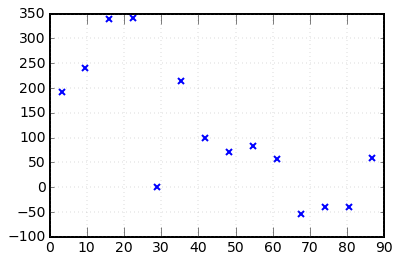

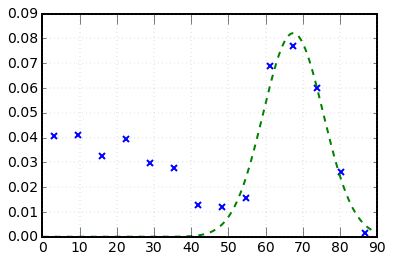

In [72]:
plt.figure()
plt.plot(fit_x[:],fit_std[:], 'x')


plt.figure()
plt.plot(fit_x, peak_max, 'x')


pfit = np.polyfit(fit_x[8:], peak_max[8:], deg=2)
myx = np.linspace(0, 90, 500)
peak_fcn = np.poly1d(pfit)
#plt.plot(myx, peak_fcn(myx), '-r')

popt, pcov = optimize.curve_fit(gaus,fit_x[8:], peak_max[8:],p0=[0.08, 70, 20] )
plt.plot(myx, gaus(myx, *popt), '--g')
print popt
#plt.ylim(0, 180, 'x')

#### There are 3 components:<br>-The flat component<br>-The Gaussian centered at 180 degrees with a std deviation that changes from 100 at 30deg to 50 at 90 deg<br>-The peaks every 40 degrees

In [43]:
exp_func = lambda x, a, b, c: a*np.exp((b-c)/x)

In [44]:
overx_func = lambda x, a, x0: a/(x-x0)

In [45]:
one_fit, cov = optimize.curve_fit(overx_func, fit_x[5:], fit_std[5:],
                         p0 = (100, -3))

In [46]:
print one_fit

[ 1618.68056587    28.38572085]


(0, 200)

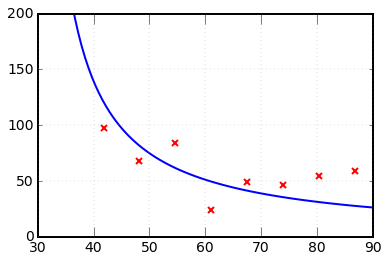

In [47]:
xlist = np.linspace(30, 90, 100)
result = overx_func(xlist, *one_fit)
plt.plot(xlist, result)
plt.plot(fit_x[5:],fit_std[5:], 'xr')
plt.ylim([0, 200])

In [57]:
print overx_func(35, *one_fit)
print one_fit

244.725166571
[ 1618.68056587    28.38572085]


In [79]:
def reflectPetalsParams(theta):
    a  = 1618.68056587
    x0 = 28.38572085
    xlim = 35.
    if theta < xlim:
        # Uniform distribution
        return False
    else:
        gauss_std = a/(theta-x0)
        
    # The height of the peak (derived from MC)
    peak_height = gaus(theta, 0.08211415,  67.44448896,  -8.07978196)
    
    return gauss_std, peak_height

In [275]:
def reflectPetalsPDF(theta):
    # The peak structure makes this distribution hard to handle
    # Drawing a value will be divided in two - see next function
    xlim = 35.
    peak_factor = 2.
    n_peaks = 9

    phi_edges = np.arange(0, 361, 4)
    phi_bins  = (phi_edges[1:]+phi_edges[:-1])/2.
    
    if theta < xlim:
        return phi_edges, [1./len(phi_bins)]*len(phi_bins)
    
    peaks    = np.array(([True] + [False]*8 + [True])*9)
    
    gauss_std, peak_height = reflectPetalsParams(theta)
    gauss_mean = 180.
    
    peak_fraction = n_peaks*peak_height
    
    this_pdf = gaus(phi_bins, 1., gauss_mean, gauss_std)
    this_pdf *= (1-peak_fraction)/this_pdf.sum()
    
    this_pdf[peaks] += (peak_height/peak_factor)

    return phi_edges,this_pdf
    
        

In [333]:
def drawValuePetalsPDF(theta):
    # Start by drawing a random value
    one_random = np.random.rand()
    xlim = 35.
    n_peaks    = 9
    peak_width = 4. # In degrees
    
    if theta < xlim:
        # Flat distribution - return the scaled random value
        return one_random*360.
    
    gauss_std, peak_height = reflectPetalsParams(theta)
    gauss_mean = 180.
    
    # Determine the fraction of the sample that goes into the peaks
    peak_fraction = n_peaks*peak_height
    
    #print 'Peak fraction ', peak_fraction
    
    # Is it a peak event or not?
    if one_random < peak_fraction:
        # Peak event
        this_peak = np.random.randint(0, 9)*(360/9.)
        return this_peak
    
    # If it is not a peak event, just draw a value from the gaussian distribution
    # The standard deviation is pretty large. Trick to avoid going over the valid range.
    random_value = np.random.normal(180., gauss_std)
    if 0 < random_value < 360.:
        return random_value
    else:
        return one_random*360.

    

In [336]:
# Getting the PDF from drawing values
phi_result = np.zeros(10000)
in_theta = np.linspace(0., 90., 101)
y = np.linspace(0, 360., 51)

output = np.zeros([in_theta.size, y.size-1])

for i in range(in_theta.size):
    this_theta = in_theta[i]
    for j in range(phi_result.size):
        phi_result[j] = drawValuePetalsPDF(this_theta)
    #raw_input()
    b, yaux = np.histogram(phi_result, y)
    output[i,:] = b


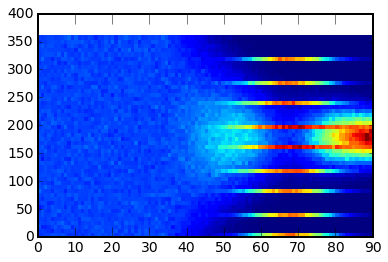

In [337]:
plt.pcolor(in_theta, y, output.T)

(0, 360)

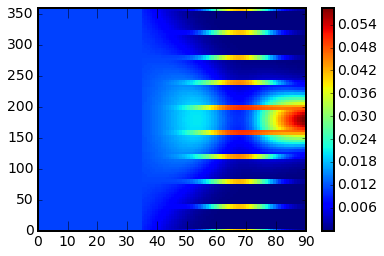

In [310]:
y = pdf_edges
in_theta = np.linspace(0., 90., 101.)
output = np.zeros([len(in_theta), len(y)-1])

for i in range(len(in_theta)):
    edges, content = reflectPetalsPDF(in_theta[i])
    output[i,:] = content
    
plt.pcolor(in_theta, y, output.T)
plt.colorbar()
plt.ylim(0,360)